# **libraries**

In [1]:
import cv2
from PIL import ImageFont, ImageDraw, Image, ImageOps
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime as dt
import tensorflow as tf

# **functions**

In [6]:
def data_gen(font_folder, font_list,
             data_str = "0 1 2 3 4 5 6 7 8 9",  
             img_size = (12000, 256), e_kernel_size = (1,1), d_kernel_size = (30, 3),
             w_min = 0, w_max = 200, h_min = 0, h_max = 200,
             ang_lb = -12, ang_ub = 13, ang_off = 4,
             area_thres = 0.4, 
             dial_ub = 11, dial_off = 2, 
             count_start = 0, show_bool = False):
  
  #color and font size
  color = 255 
  font_size = 128 
  
  #list to store images and labels
  all_roi = []
  all_labels = []
  
  #loop over to generate data
  #loope over fonts
  for i,f in enumerate(font_list):
    print("\nfont",i+1, ":", f)
    font = ImageFont.truetype(font_folder + f, font_size)
    
    #iterate over angles
    for ang in range(ang_lb,ang_ub,ang_off):
        print("angle", ang, end = ", ")      
        
        #generate image
        #blank image
        img = Image.new('L', img_size, "black")
        #position of text
        x = 10
        y = img_size[1]//2 - font_size//2
        #draw text on image
        draw = ImageDraw.Draw(img)
        draw.text((x, y), data_str, fill = 255, font=font) 
        #roatate written text on image
        img=img.rotate(ang,  expand=1)
        #convert image from PIL format to array
        img = np.array(img)        
  #       plt.imshow(img, cmap = 'gray')
  #       plt.show()
        
        #kernel for erosion
        e_kernel = np.ones(e_kernel_size, np.uint8)
        #erode image
        inp = cv2.erode(img, e_kernel, iterations=1)
        #kernel for dilation
        d_kernel = np.ones(d_kernel_size, np.uint8)
        #dilate image
        inp = cv2.dilate(inp, d_kernel, iterations=1) 
  
        #find contours
        ctrs, hier = cv2.findContours(inp.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        #sort contours
        sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])  
        
        count = count_start
        rois = []
        labels = []        
        for i, ctr in enumerate(sorted_ctrs):
          discard = 0
          # get bounding box
          x, y, w, h = cv2.boundingRect(ctr) 
          #discard if box size is smaller or larger than desired
          if w>w_min and h>h_min and w<w_max and h<h_max:
            #remove overlaping boxes
            for j, temp_ctrs in enumerate(sorted_ctrs):
              temp_x, temp_y, temp_w, temp_h = cv2.boundingRect(temp_ctrs)
              if j != i and temp_w <w_max and temp_h <h_max:
                #if there is overlap and intersection area is more than threshold then discard the bounding box
                 if (temp_x<x<temp_x+temp_w and temp_y<y<temp_y+temp_h) or (temp_x<x+w<temp_x+temp_w and temp_y<y+h<temp_y+temp_h):
                  dx = min((temp_x + temp_w),(x+w)) - max(temp_x, x)
                  dy = min((temp_y + temp_h),(y+h)) - max(temp_y, y)
                  if(dx*dy>0):
                    intersection_area = dx * dy
                  else:
                    intersection_area = 0
                  if (intersection_area/(w*h) > area_thres):
                    discard += 1
                    break
            #if not discarded then add bounding box in list
            if discard == 0: 
#               roi = img[y+22:y+h-22, x:x+w] 
              roi = img[y:y+h-10, x:x+w-5] 
              #reshape segmented character
              roi = cv2.resize(roi, (128,128))
              #dilate segment character to get different thickness
              for i in range(1, dial_ub, dial_off):
                kernel = np.ones((i,i), np.uint8)
                dilated_roi = cv2.dilate(roi, kernel, iterations=1)
                all_roi.append(dilated_roi)
                rois.append(dilated_roi)
                all_labels.append([count])
                labels.append([count])
              count = count + 1
        print("\ntotal number of segmented image for angle", ang,':', len(rois))
        
        #dispaly segmented images
        if(show_bool == True and ang == 0):
          fig=plt.figure(figsize=(18, 18))
          for i, r in enumerate(rois):
            fig.add_subplot(20,20, i+1)
            plt.imshow(r, cmap='gray')
          plt.show()
          print(labels)
    
  return all_roi, all_labels

In [7]:
def _bytes_feature(value):
  return tf.train.Feature \
         (bytes_list=tf.train.BytesList(value=[value]))

def write_tfrecords(all_features, all_labels, file):
  '''
  write data to a tfrecords file
  '''
  start_time=dt.now()
  print("writing .tfrecords file for data...")
  writer = tf.python_io.TFRecordWriter(file)
  for features, labels in zip(all_features, all_labels):
      feature = {'labels': _bytes_feature(tf.compat.as_bytes \
                           (np.array(labels).tostring())),
                 'images': _bytes_feature(tf.compat.as_bytes \
                           (np.array(features).tostring()))}
      example = tf.train.Example(features=tf.train.Features \
                                 (feature=feature))
      writer.write(example.SerializeToString())    
  writer.close()
  end_time = dt.now()  
  print("time taken to write data", end_time - start_time)

# **Generate data**

In [8]:
font_folder = '/home/supernova/Jobs/OCR/begining/OCR_Part3-20190807T133620Z-001/OCR_Part3/fonts/'
font_list = os.listdir(font_folder) #list of all fonts

digit = '0 1 2 3 4 5 6 7 8 9 ' #all digits
lc = 'a b c d e f g h i j k l m n o p q r s t u v w x y z ' #all lower case
all_uc = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ' #all upper case
sel_uc = 'A B D E F G H J K L M N Q R T Y ' #selected upper case
all_sign = '''! @ # % ^ & ? / ( ) { } [ ] < > * - + = \ : ; ' . ''' #all useful signs
sel_sign = '''. ( ) % ''' #selected signs

digi_perc = digit + '% ' #digits with percentage

digi_lc = digit + lc #digits and all lower case
digi_uc = digit + all_uc #digitand all upper case
all_letters = lc + all_uc #all letters
digi_all_letters = digi_lc + all_letters #all digits and all letters
digi_all_letters_all_sign = digi_all_letters + all_sign #all digits, all letters and all useful signs

lc_sel_uc = lc + sel_uc
digi_lc_sel_uc = digit + lc + sel_uc
digi_all_letters_sel_sign = digi_all_letters + sel_sign # all digit, all letters and selected signs
digi_lc_sel_uc_sel_sign = digi_lc + sel_uc + sel_sign # all digits, all lower case, selected upper case and selected signs
digi_lc_sel_uc_all_sign = digi_lc + sel_uc + all_sign # all digits, all lower case, selected upper case and all signs

In [9]:
fl = font_list #list of fonts
ds = digi_lc_sel_uc_sel_sign #list of characters
ims = (len(ds)*150, 256) #main image (with all characters) size

eks = (1,1) #size of erosion kernel
dks = (20,10) #size of dilation kernel
alb = -12 #lower bound of range of angle
aub = 13 #upper bound of range of angle
aoff = 4 #offset for range of angle
wmi = 0 #10 #minimum acceptable width of bounding box
wma = 200 #maximum acceptable width of bounding box
hmi = 0 #30 #minimum acceptable height of bounding box
hma = 200 #maximum acceptable height of bounding box
at = 0.4 #minimum overlaped area to reject a bounding box
dub = 11 #upper bound for range of dilation kernel size
doff = 2 #offset for range of dilation kernel size
cs = 0 # segment count starts from 

print("data string:", ds)
print("total number of character:", len(ds)/2)

data, labels = data_gen(font_folder, fl,
                       data_str = ds, 
                       img_size = ims, e_kernel_size = eks, d_kernel_size = dks,
                       w_min = wmi, w_max = wma, h_min = hmi, h_max = hma,
                       ang_lb = alb, ang_ub = aub, ang_off = aoff,
                       area_thres = at, 
                       dial_ub = dub, dial_off = doff,
                       count_start = cs, show_bool = 0)

print("\nlength of image list:", len(data))
print("length of label list:", len(labels))

data string: 0 1 2 3 4 5 6 7 8 9 a b c d e f g h i j k l m n o p q r s t u v w x y z A B D E F G H J K L M N Q R T Y . ( ) % 
total number of character: 56.0

font 1 : Open Sans.ttf
angle -12, 
total number of segmented image for angle -12 : 280
angle -8, 
total number of segmented image for angle -8 : 280
angle -4, 
total number of segmented image for angle -4 : 280
angle 0, 
total number of segmented image for angle 0 : 280
angle 4, 
total number of segmented image for angle 4 : 280
angle 8, 
total number of segmented image for angle 8 : 280
angle 12, 
total number of segmented image for angle 12 : 280

font 2 : SourceSansPro-Regular.ttf
angle -12, 
total number of segmented image for angle -12 : 280
angle -8, 
total number of segmented image for angle -8 : 280
angle -4, 
total number of segmented image for angle -4 : 280
angle 0, 
total number of segmented image for angle 0 : 280
angle 4, 
total number of segmented image for angle 4 : 280
angle 8, 
total number of segmented image fo

Total numbr of data: 29400
label: [0]; label: [1]; label: [2]; label: [3]; label: [4]; label: [5]; label: [6]; label: [7]; label: [8]; label: [9]; label: [10]; label: [11]; label: [12]; label: [13]; label: [14]; label: [15]; label: [16]; label: [17]; label: [18]; label: [19]; label: [20]; label: [21]; label: [22]; label: [23]; label: [24]; label: [25]; label: [26]; label: [27]; label: [28]; label: [29]; label: [30]; label: [31]; label: [32]; label: [33]; label: [34]; label: [35]; label: [36]; label: [37]; label: [38]; label: [39]; label: [40]; label: [41]; label: [42]; label: [43]; label: [44]; label: [45]; label: [46]; label: [47]; label: [48]; label: [49]; label: [50]; label: [51]; label: [52]; label: [53]; label: [54]; label: [55]; 

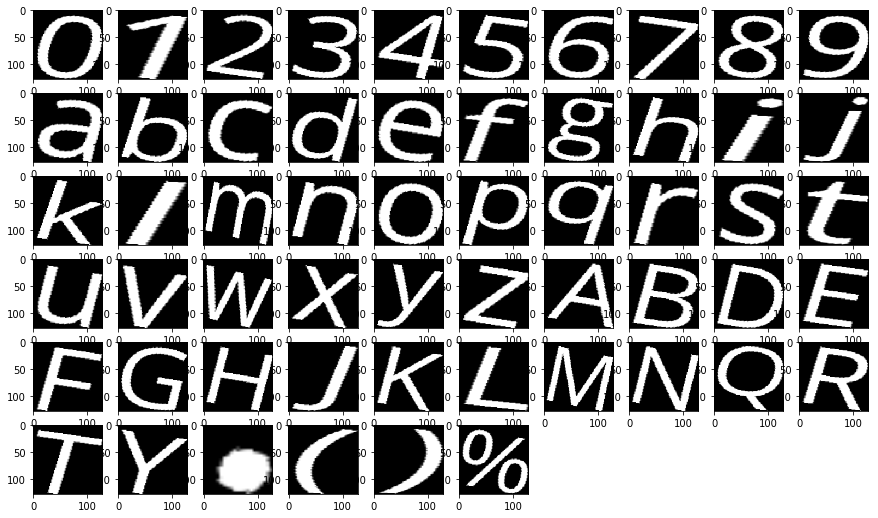

In [10]:
fig=plt.figure(figsize=(15, 15))
print('Total numbr of data:', len(data))
for i, (d, l) in enumerate(zip(data, labels)):
  if i < 5*((len(ds))/2) and i%5==0:
    print("label:", l, end = "; ")
    fig.add_subplot(10,10,(i/5+1))
    plt.imshow(d, cmap = 'gray')
plt.show()

# **create tfrecord**

In [11]:
folder_path = '/home/supernova/Jobs/OCR/begining/OCR_Part3-20190807T133620Z-001/OCR_Part3/dataset/test_records/'

#comment include: total data, total characters, total fonts
filename_digi_lc_sel_uc_sel_sign = folder_path + 'dataset_digi_lc_sel_uc_sel_sign_1.tfrecords' # 29400, 56, 15

In [13]:
filename = filename_digi_lc_sel_uc_sel_sign
write_tfrecords(data, labels, filename)

writing .tfrecords file for data...
time taken to write data 0:00:01.289514


# **Check**

In [14]:
import cv2
from PIL import ImageFont, ImageDraw, Image 
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime as dt
import tensorflow as tf

In [15]:
def read_data(file_list):
  '''
  read data from tfrecords file
  '''
  file_queue=tf.train.string_input_producer(file_list)
  feature = {'images': tf.FixedLenFeature([], tf.string),
             'labels': tf.FixedLenFeature([], tf.string)}    
  reader = tf.TFRecordReader()  
  _,record=reader.read(file_queue)#read a record
  features = tf.parse_single_example(record, features=feature)
  img = tf.decode_raw(features['images'], tf.uint8)
  label = tf.decode_raw(features['labels'], tf.uint8) 
  return img,label

def minibatch(batch_size, filename, file_count, image_size, max_char, class_count):
  '''
  create minibatch
  '''
  file_list=[os.path.join(filename + '%d.tfrecords' % i) for i in range(1, file_count+1)]  
  img, label = read_data(file_list)
  img = tf.cast(tf.reshape(img,img_size), dtype = tf.float32)
  label = tf.reshape(label[0], [1, max_char])# added [0] as workaround, need to resolve the issue
  label = tf.one_hot(label[0],class_count,axis=1)# added [0] as workaround, need to resolve the issue
  label = tf.reshape(label,tf.shape(label)[1:])
  img_batch,label_batch= tf.train.shuffle_batch([img, label],
                          batch_size,capacity,min_after_dequeue,num_threads=num_of_threads)
  return img_batch, tf.cast(label_batch, dtype = tf.int64)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.
Instructions for updating:
Queue-base

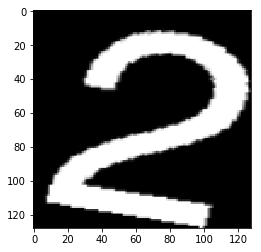

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(32, 128, 128, 1)
<class 'numpy.float32'>
<class 'numpy.int64'>
shape of image_batch: (32, 128, 128, 1)
shape of label_out: (32, 57)


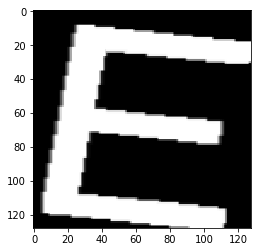

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(32, 128, 128, 1)
<class 'numpy.float32'>
<class 'numpy.int64'>
shape of image_batch: (32, 128, 128, 1)
shape of label_out: (32, 57)


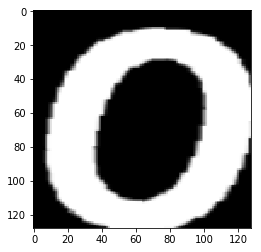

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(32, 128, 128, 1)
<class 'numpy.float32'>
<class 'numpy.int64'>
shape of image_batch: (32, 128, 128, 1)
shape of label_out: (32, 57)


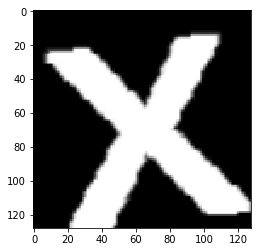

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(32, 128, 128, 1)
<class 'numpy.float32'>
<class 'numpy.int64'>
shape of image_batch: (32, 128, 128, 1)
shape of label_out: (32, 57)


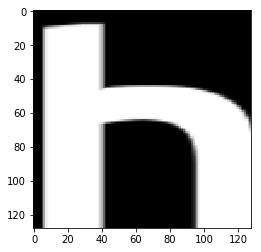

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
folder_path = '/home/supernova/Jobs/OCR/begining/OCR_Part3-20190807T133620Z-001/OCR_Part3/dataset/test_records/'
train_filename = folder_path + 'dataset_digi_lc_sel_uc_sel_sign_'
file_count = 1
img_size = [128,128,1]
max_char = 1
class_count = 57 #change this when filename is changed
batch_size = 32

num_of_threads=16
min_after_dequeue=10000
capacity=min_after_dequeue+(num_of_threads+1)*batch_size


with tf.Graph().as_default():
  image_batch, label_batch=minibatch(batch_size, train_filename, file_count, img_size, max_char, class_count)
  init=tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord) 
    for i in range(5):
      image_out, label_out= sess.run([image_batch, label_batch])
      print(image_out.shape)
      print(type(image_out[0][0,0,0]))
      print(type(label_out[0][0]))
      print("shape of image_batch:", image_out.shape)
      print('shape of label_out:', label_out.shape)
      plt.imshow(np.reshape(image_out[0],[128,128]), cmap = 'gray')
      plt.show()
      print(label_out[0])
    coord.request_stop()
    coord.join(threads)